<a href="https://colab.research.google.com/github/MuhammadNurilHuda/ImageRetrievalProject/blob/master/Tugas%20Besar/Diabet_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -O Dataset2.zip https://github.com/MuhammadNurilHuda/MachineLearningProject/blob/main/Dataset/Dataset2.zip?raw=true

--2022-01-04 05:38:54--  https://github.com/MuhammadNurilHuda/MachineLearningProject/blob/main/Dataset/Dataset2.zip?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/MuhammadNurilHuda/MachineLearningProject/raw/main/Dataset/Dataset2.zip [following]
--2022-01-04 05:38:54--  https://github.com/MuhammadNurilHuda/MachineLearningProject/raw/main/Dataset/Dataset2.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MuhammadNurilHuda/MachineLearningProject/main/Dataset/Dataset2.zip [following]
--2022-01-04 05:38:54--  https://raw.githubusercontent.com/MuhammadNurilHuda/MachineLearningProject/main/Dataset/Dataset2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Praktikum_Machine_Learning/
!ls

/content/drive/MyDrive/Praktikum_Machine_Learning
'=0.0.7'		  model_resnet_diabet.tflite
'BreaKHis 400X'		  model_weight.h5
 data			  modul3_1.h5
 dataset		  modul3_2.h5
 Dataset2.zip		  natural_images
 dataset_split		  natural_image_split
 Gather_tkc		  natural-images.zip
 hparams_demo_logs.zip	 'Plantar Thermogram'
 kaggle.json		  README_rpc-cv-images.txt
 logs			  rps-cv-images
 model1_diabet_25.h5	  ThermoDataBase
 model1_diabet.h5	 '(versi 3) Kegiatan Modul 1 Nuril.ipynb'
 model1_modul4.h5	 '(versi 3) Kegiatan Modul 2-003.ipynb'
 model2.h5		 '(versi 3) Kegiatan Modul 3.ipynb'
 model2_modul4.h5	 '(versi 3) Kegiatan Modul 4.ipynb'
 model.h5		 'WhatsApp Image 2021-11-27 at 1.49.05 PM (1).jpeg'
 model_heroku.h5	 'WhatsApp Image 2021-11-27 at 1.49.05 PM.jpeg'
 model.json		 'WhatsApp Image 2021-11-27 at 1.51.51 PM.jpeg'
 model_resnet_diabet.h5


In [5]:
import zipfile
local_zip = "/content/drive/MyDrive/Praktikum_Machine_Learning/Dataset2.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/MyDrive/Praktikum_Machine_Learning/Plantar Thermogram')
zip_ref.close()

In [6]:
pip install split-folders

In [7]:
import splitfolders

splitfolders.ratio('/content/drive/MyDrive/Praktikum_Machine_Learning/Plantar Thermogram/Dataset', output="/content/drive/MyDrive/Praktikum_Machine_Learning/Plantar Thermogram/Splitted", seed=42, ratio=(.85, .05, .1), group_prefix=None)

Copying files: 334 files [01:06,  5.05 files/s]


In [8]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [9]:
print(tf.__version__)

2.7.0


In [10]:
from skimage import img_as_float
from skimage import exposure
import plotly.graph_objects as go

import os
import glob
import random
from skimage import io # To preprocess the images
from skimage.io import imread
from skimage.transform import resize
from distutils.file_util import copy_file
import seaborn as sns
import cv2
import keras
from keras.models import load_model
from keras import backend as K
import tensorflow as tf
import numpy as np

from skimage.transform import rescale
from keras_preprocessing.image import ImageDataGenerator

import warnings
warnings.simplefilter('ignore')

In [11]:
base_dir = '/content/drive/MyDrive/Praktikum_Machine_Learning/Plantar Thermogram/Splitted'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')
cls = ['Negatif', 'Positif']

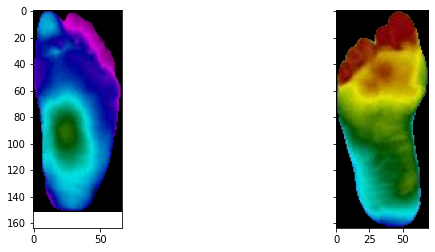

In [12]:
neg_path = os.path.join(train_dir, cls[0], '*')
neg = glob.glob(neg_path)
neg = io.imread(neg[0])

pos_path = os.path.join(train_dir, cls[1], '*')
pos = glob.glob(pos_path)
pos = io.imread(pos[0])

f, axes = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)

axes[0].imshow(neg, cmap='gray')
axes[1].imshow(pos, cmap='gray')

In [13]:
def plot_img_and_hist(image, axes, bins=256):
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

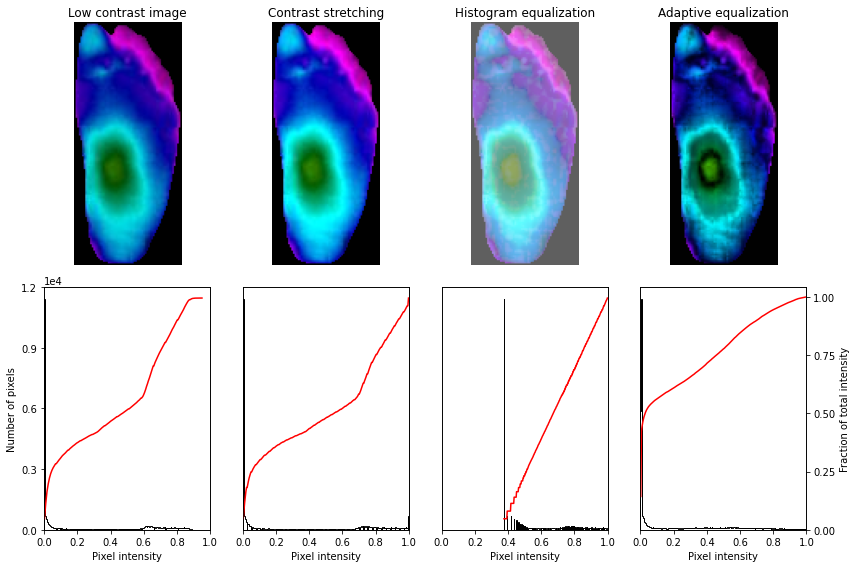

In [14]:
img = neg

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(12, 8))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

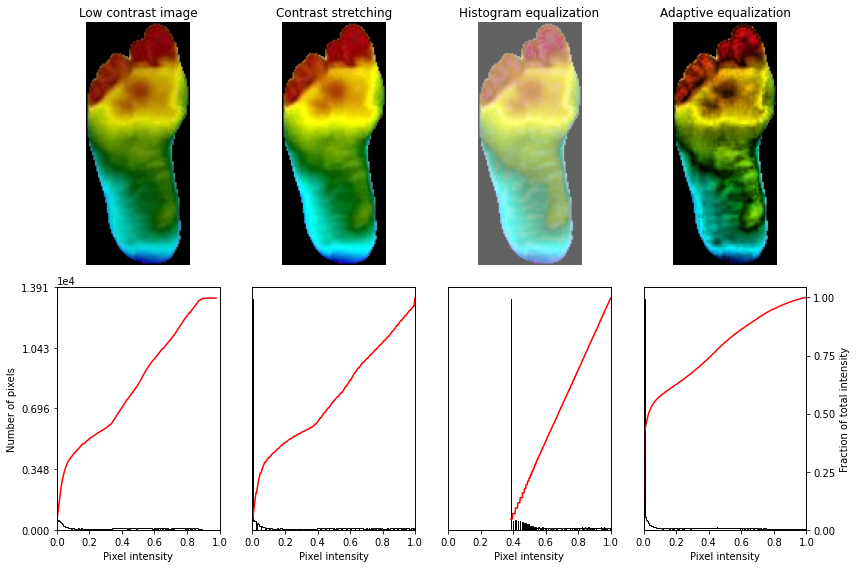

In [15]:
img = pos

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(12, 8))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

In [16]:
neg_train_dir = os.path.join(train_dir, 'Negatif')
pos_train_dir = os.path.join(train_dir, 'Positif')

neg_val_dir = os.path.join(val_dir, 'Negatif')
pos_val_dir = os.path.join(val_dir, 'Positif')

In [17]:
print("Total Training NORMAL:", len(os.listdir(neg_train_dir)))
print("Total Training PNEUMONIA:", len(os.listdir(pos_train_dir)))
print()
print("Total validation NORMAL:", len(os.listdir(neg_val_dir)))
print("Total validation PNEUMONIA:", len(os.listdir(pos_val_dir)))

Total Training NORMAL: 76
Total Training PNEUMONIA: 207

Total validation NORMAL: 9
Total validation PNEUMONIA: 24


In [18]:
def gather_data(data_dir):
    dir_data = []
    dir_label = []

    for dirpath, dirnames, filenames in os.walk(data_dir):
        for file in filenames:
            if ".png" in file:
                image_path = os.path.join(dirpath, file)

                image = cv2.imread(image_path)
                image = cv2.resize(image, (150,150))
                image = image.astype('float32') / 255.0
                dir_data.append(image)

                label = int((image_path.split(os.path.sep)[-2]) == 'Positif')
                dir_label.append(label)

    dir_data = np.array(dir_data)
    dir_label = np.array(dir_label)

    return dir_data, dir_label

In [19]:
x_train, y_train = gather_data(train_dir)
x_val, y_val = gather_data(val_dir)

In [20]:
gather_save = '/content/drive/MyDrive/Praktikum_Machine_Learning/Gather_tkc'

In [21]:
preprocessed_data = [x_train, y_train, x_val, y_val]
preprocessed_file_name = ['x_train', 'y_train', 'x_val', 'y_val']
for i, file_name in enumerate(preprocessed_file_name):
    np.save(gather_save + '/' + file_name + '.npy', preprocessed_data[i])

In [22]:
x_train = np.load(gather_save + '/x_train.npy')
y_train = np.load(gather_save + '/y_train.npy')

x_val = np.load(gather_save + '/x_val.npy')
y_val = np.load(gather_save + '/y_val.npy')

In [23]:
print("Train Data = ", x_train.shape)
print("Train Label = ", y_train.shape)
print()
print("Val Data = ", x_val.shape)
print("Val Label = ", y_val.shape)

Train Data =  (283, 150, 150, 3)
Train Label =  (283,)

Val Data =  (33, 150, 150, 3)
Val Label =  (33,)


In [24]:
def conv_block(filters):
    block = Sequential([
        SeparableConv2D(filters, 3, activation='relu', padding='same'),
        SeparableConv2D(filters, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D()
    ])
    return block
def dense_block(units, dropout_rate):
    block = Sequential([
        Dense(units, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate)
    ])
    return block

def build_model():
    model = Sequential([
              Input(shape=(150, 150, 3)),
              Conv2D(32, kernel_size=3, activation='relu'),
              MaxPool2D(2,2),

              Conv2D(32, kernel_size=3, activation='relu'),
              MaxPool2D(2,2),

              Conv2D(64, kernel_size=3, activation='relu'),
              MaxPool2D(2,2),

              conv_block(64),
              conv_block(128),
              Dropout(0.25),
              conv_block(256),

              Dropout(0.25),

              Flatten(),

              dense_block(512, 0.7),
              dense_block(128, 0.5),
              dense_block(64, 0.3),

              Dense(1, activation='sigmoid')
                        ])
    return model

In [25]:
print("Total Training Negatif:", len(os.listdir(neg_train_dir)))
print("Total Training Positif:", len(os.listdir(pos_train_dir)))

Total Training Negatif: 76
Total Training Positif: 207


In [26]:
norm_data_count = len(os.listdir(neg_train_dir))
pneu_data_count = len(os.listdir(pos_train_dir))

print(f"Jumlah Negatif: {norm_data_count}\nJumlah Positif: {pneu_data_count}")

Jumlah Negatif: 76
Jumlah Positif: 207


In [27]:
weight_for_0 = (1 / norm_data_count) * (x_train.shape[0]) / 2.0 
weight_for_1 = (1 / pneu_data_count) * (x_train.shape[0]) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.86
Weight for class 1: 0.68


In [28]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, InputLayer, MaxPool2D, SeparableConv2D
from tensorflow.keras.metrics import Precision, Recall

In [29]:
model = build_model()

METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')]

In [30]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=METRICS)

In [31]:
history = model.fit(x_train, y_train,
              epochs=100,
              validation_data=(x_val, y_val)
              )

Epoch 1/100
9/9 [==============================] - 13s 1s/step - loss: 0.9093 - accuracy: 0.5194 - precision: 0.7518 - recall: 0.5121 - val_loss: 0.6797 - val_accuracy: 0.7273 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 2/100
9/9 [==============================] - 8s 925ms/step - loss: 0.8160 - accuracy: 0.5477 - precision: 0.7687 - recall: 0.5459 - val_loss: 0.6660 - val_accuracy: 0.7273 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 3/100
9/9 [==============================] - 8s 911ms/step - loss: 0.7126 - accuracy: 0.6254 - precision: 0.8217 - recall: 0.6232 - val_loss: 0.6522 - val_accuracy: 0.7273 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 4/100
9/9 [==============================] - 8s 913ms/step - loss: 0.7403 - accuracy: 0.5866 - precision: 0.7961 - recall: 0.5845 - val_loss: 0.6404 - val_accuracy: 0.7273 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 5/100
9/9 [==============================] - 8s 922ms/step - loss: 0.6304 - accuracy: 0.6749 - precision

In [32]:
import json
target_dir = '/content/drive/MyDrive/Praktikum_Machine_Learning'

In [33]:
history_dict = history.history
json.dump(history_dict, open(target_dir + '/model_retrieavl.json', 'w'))

model.save(target_dir + '/model_retrieavl.h5')
model.save_weights(target_dir + '/model_weight_retrieavl.h5')

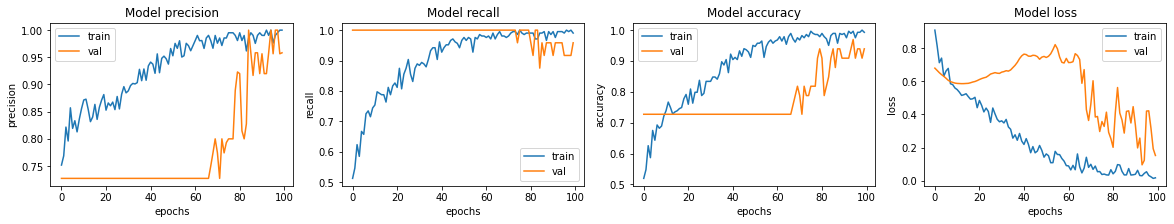

In [34]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [35]:
# save_dir = target_dir

# checkpoint_cb = ModelCheckpoint(save_dir + "/best_model_tuning.h5",
#                                 save_best_only=True)

# early_stopping_cb = EarlyStopping(patience=25,
#                                   restore_best_weights=True)

In [36]:
loss, acc, prec, rec = model.evaluate(x_val, y_val)
print(f"Accuracy = {acc * 100:.2f} %")
print(f"Precision = {prec * 100:.2f} %")
print(f"Recall = {rec * 100:.2f} %")

2/2 [==============================] - 0s 17ms/step - loss: 0.1519 - accuracy: 0.9394 - precision: 0.9583 - recall: 0.9583
Accuracy = 93.94 %
Precision = 95.83 %
Recall = 95.83 %


In [37]:
loss, acc, prec, rec = model.evaluate(x_train, y_train)
print(f"Accuracy = {acc * 100:.2f} %")
print(f"Precision = {prec * 100:.2f} %")
print(f"Recall = {rec * 100:.2f} %")

9/9 [==============================] - 2s 243ms/step - loss: 0.0026 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Accuracy = 100.00 %
Precision = 100.00 %
Recall = 100.00 %
